# Info from the notebooks on SSJ

SSJ has several subclasses of the abstract **Block** class.
- `SimpleBlock` (`sj.@simple`) for explicit aggregate equilibrium conditions
- `SolvedBlock` (`@sj.solved`) for implicit aggregate equilibrium conditions
- `HetBlock` (`@sj.het`) for collective actions of heterogeneous agents
- `CombinedBlock` for combination of multiple blocks

They are followed with by a fct definition.

Notation conventions are as follows: 
   - `Y` refers to $Y_t$
   - `Y(-k)` refers to $Y_{t-k}$
   - `Y(k)` refers to $\mathbb{E}_t[Y_{t+k}]$
   - lag variables cannot be inputted but you can cal them from another bock (fct) that returns the lag of a var given the var.

# Understanding HH block


In [184]:
import numpy as np
import sequence_jacobian as sj # sequence-space Jacobian toolkit
from scipy import linalg

In [185]:
# Income process from Kaplan Moll Violante 2018
# load KMV transition matrix, convert to discrete time, and fix rounding so rows sum to 1
Pi_e = linalg.expm(np.loadtxt('inputs/kmv_process/ymarkov_combined.txt'))
Pi_e /= np.sum(Pi_e, axis=1)[:, np.newaxis]


`Pi_e` = ($n_e$ X $n_e$) Transition Matrix for Income (the probabilities of transitioning between different income states). The rows of Pi_e correspond to the current state, and the columns correspond to the next state. They normalize it so that each rows is equal to 1 (ensuring valid probabilities).

`np.loadtxt`: Reads the text doc in the folders inputs/kmv_process/ that shows the income transition matrix. 

`linalg.expm` = Compute the matrix exponential of an array to convert it from a continuous-time to a discrete-time Markov process.

`np.sum(Pi_e, axis=1)`= compute the sum of each row in the matrix => outputs array of shape (n,) with each element inside on n the sum of a row (n rows).

`[:, np.newaxis]` changes its shape to (n, 1).

`/=` = division of each element of `Pi_e` => normalizing, and each row will sum one. WHY? each value of a row is a state you can acces in the next period and the sum of the probabilities of the different states must be one. 

In [186]:
pi_e = sj.utilities.discretize.stationary(Pi_e) # need to find the official function definition
e_grid_short = np.exp(np.loadtxt('inputs/kmv_process/ygrid_combined.txt'))
# the exponential of a grid of logarithmic income levels => actual income levels
e_grid_short /= e_grid_short @ pi_e # normalize so that the mass of agents is always 1?
n_e = len(pi_e) 

`sj.utilities.discretize.stationary` = calculates the stationary distribution of the Markov chain (LR/equilibrium distribution of agents across income states)

`pi_e`= $n_e$-dimensional vector. The distribution of income states at equilibrium. For example [0.1, 0.2 ..., 0.3]

`e_grid_short`=  $n_e$-dimensional vector (income level).The income grid (loaded and exponenetialized to get the actual income levels). For example, [0.5, 1.0, 1.5,...]

`n_e`= the number of income types/states (all elements in `pi_e`)


In [187]:
print(e_grid_short.shape) #(33,)
print(e_grid_short)
print(n_e)
print(pi_e)
# there are 33 possible income states

(33,)
[5.31799183e-03 1.22858520e-02 2.54242529e-02 3.52904806e-02
 4.64164330e-02 7.28630066e-02 8.15295765e-02 9.18445392e-02
 1.15770948e-01 1.68716713e-01 1.81733469e-01 2.34189521e-01
 3.08021947e-01 3.31786343e-01 4.83522832e-01 5.41034667e-01
 6.09485316e-01 6.86596207e-01 7.68262273e-01 1.11961314e+00
 1.20599312e+00 1.58620398e+00 2.04405029e+00 2.20175193e+00
 3.20868366e+00 4.04457743e+00 4.55628946e+00 5.09822978e+00
 8.00303526e+00 1.05261346e+01 1.46109446e+01 3.02357826e+01
 6.98519972e+01]
33
[2.63255204e-04 7.31719227e-04 1.53413313e-03 8.94710875e-03
 2.55626630e-03 3.27734757e-03 2.48685358e-02 1.10627972e-02
 3.27734757e-03 5.21397327e-02 2.55626630e-03 2.63255204e-04
 8.68784064e-02 1.53413313e-03 1.11385396e-01 7.31719227e-04
 3.75985161e-01 7.31719227e-04 1.11385396e-01 1.53413313e-03
 8.68784064e-02 2.63255204e-04 2.55626630e-03 5.21397327e-02
 3.27734757e-03 1.10627972e-02 2.48685358e-02 3.27734757e-03
 2.55626630e-03 8.94710875e-03 1.53413313e-03 7.31719227e-0

In [188]:
# return b values, probability of drawing each, probability of moving from one beta state 
# to another (including staying at the current one)

def make_betas(beta_hi, dbeta, omega, q):
    """Return beta grid [beta_hi-dbeta, beta_high] and transition matrix,
    where q is probability of getting new random draw from [1-omega, omega]"""
    # q = prob of drawing new b
    # omega = prob of getting beta high
    beta_lo = beta_hi - dbeta
    # beta high = patient; beta low = impatient; dbeta = difference
    b_grid = np.array([beta_lo, beta_hi]) # 1D-array with two elements with each beta value
    pi_b = np.array([1 - omega, omega])
    #2-value array with probability of bhigh, blow if a random draw is needed
    Pi_b = (1-q)*np.eye(2) + q*np.outer(np.ones(2), pi_b)
    return b_grid, Pi_b, pi_b

`np.eye(2)` returns a 2x2 identity matrix => the matrix gets multiplied by the probability of not having to draw a new beta => on the diagonal, 0 otherwise.

`np.ones(2)` returns a 1x2 "ones" matrix (vector)

`np.outer`computes the products of all values of two vectors (here of size 2 and 2) => returns a matrix of size (2,2) => technically duplicates pi_b into two rows => then multiplies all by q

`Pi_b` = 2x2 matrix. diagonals: probs of staying at your current b; Other: probability of changing. First row: starting state = blow; starting state 0 bhigh.

In [189]:
def make_grids(min_a, max_a, n_a, beta_hi, dbeta, omega, q):
    ### asset and beta grids
    a_grid = sj.grids.asset_grid(min_a, max_a, n_a) # creates a grid for assets 
    #(tightly spaced for low values, the contrary for high values, as is common in HA models)

    b_grid_short, Pi_b, pi_b = make_betas(beta_hi, dbeta, omega, q) 
    # calls the make_betas fct to get the grid of two beta values, 
    # probability of switching and transition matrix for beta

    ### combine grids for beta and e (latter pre-loaded from KMV above)
    e_grid = np.kron(np.ones_like(b_grid_short), e_grid_short)
     # repeats e_grid_short for each b state
    beta = np.kron(b_grid_short, np.ones_like(e_grid_short))
    # repeats b_grid_short for each e state
    
    Pi = np.kron(Pi_b, Pi_e) 
    # Pi_b is the transition matrix for the beta states 
    # Pi_e is the transition matrix for the income states
    #combine transition matrices for joint beta and e states

    pi_pdf = np.kron(pi_b, pi_e)
    # pi_b the stationary distribution for b-types
    # pi_e the stationary distribution for e_types
    # combined mass of agents in equilibrium for each joint value of beta and e
    return e_grid, Pi, a_grid, beta, pi_pdf

`n_a`= the number of asset grid points. (ex: 200)

`min_a` and `max_a`= minimum/ maximum asset level. (ex: 0 and 4000).

`np.ones_like(b_grid_short)`= Returns an array of ones with the same shape and type as b_grid_short. (same for e_grid_short). 

Kronenberg product: "multiplies" each element of a matrix to the whole second  matrix, then expands. Denoted by ⊗. Used to combine independent Markov processes.

`e_grid`= the code creates a 1D array of ones with 2-element (same share as b_grid_short) and we know that e_grid_short is a $n_e$-dimensional vector. Thus the Kronenberg product produces a new array of shape (2*$n_e$,), it reapeats e_grid_short (the income level) for every beta. Overall, `e_grid` is an extension of `e_grid_short` 
across the beta-types. The resulting e_grid is a 1D array with each income state in e_grid_short repeated for every beta-type. 
For example: if $n_beta$ = 2, and $n_e$ = 3, then e_grid = [0.8, 1.0, 1.5, 0.8, 1.0, 1.5].

Returns:
* `a_grid` = asset grid ([Not evenly spaced but non-linear and increasing](https://github.com/shade-econ/sequence-jacobian/blob/master/src/sequence_jacobian/utilities/discretize.py))
* `e_grid`= combined grid of income states across beta types
* `beta` = Full grid of discount factors, repeated for each productivity state.
* `pi_pdf` = stationary distribution over all joint (β,e)(β,e)-states.
* `Pi`= transitions between all combinations of (β,e)(β,e)-states.

In [190]:
def income(wN_aftertax, N, e_grid, Tr_lumpsum, Tax_richest, zeta, pi_pdf):
        # after tax income, total L supply, all possible states of prod grid, lumpsum transfer, 
        # tax for the richest, cyclicality parameter (MP exercise page 17), stationary distrib 
        # over (share of agents in each) prod states

    # Auclert-Rognlie 2020 incidence function for labor income, with cyclicality parameter zeta
    # in default case with zeta = 0, this is just gamma / N = 1 and irrelevant
        
    gamma_N = e_grid ** (zeta * np.log(N)) / np.vdot(
        e_grid ** (zeta * np.log(N)), pi_pdf
    ) 

    # net after-tax income (include lump-sum transfer option)
    y = wN_aftertax * e_grid * gamma_N + Tr_lumpsum

    # also add option to tax richest type at margin
    y = y.reshape(-1, n_e)  # reshape to beta*e grid
    y[:, -1] -= Tax_richest / pi_e[-1].sum()  # tax richest e type
    y = y.ravel()  # flatten back
    return y

`gamma_N`= incidence fct in page 17. Relaxes the assumption that all benefit equally from the labor market changes that arise from a demand shock. (I didnt really understand but probably not necessary for our project). We can copy it with `zeta=0` or get rid of it/change it.

`y`= disposable income. Seems to be the after tax income multiplied by the productivity state (ie the prod state enhances or reduces the originally same wage for everybody (given labor?)) multiplied by `gamma_N` (whatever it is it must be personal and enhance differences in wages across people) + transfers from the govt

`reshape` = y (vector) is reshaped into a 2D matrix with dimensions corresponding to the number of e states, each column an increasing level of productivity.

=> tax the richest by deducing a marginal tax to the richest (in terms of income!!!) agent type that is normalized by the sum of the stationary distribution of those values of e so that all agents receive a proportional decution

=> retransform y into a vector 

Return `y` = The vector of net after-tax incomes for all agents, with possible lump-sum transfers and tax on the richest agents.

In [191]:
@sj.het( #mark of an HA block
    exogenous="Pi", policy="a", backward="Va", backward_init=sj.hetblocks.hh_sim.hh_init
)
# define the exogenous variables: matrix of prod*beta states Pi, savings (as a policy function),
# backward-looking value function, and the solving method (backwards iteration?)

def hh_raw(Va_p, a_grid, y, r, beta, eis):
    """Household block. Slightly modify sequence_jacobian.hetblocks.hh_sim.hh to allow for beta vector"""
    # Inputs: derivative of value function Va_p, grid of asset values, a certain income (?) level, the hh's beta, 
    # and elasticity of intertemporal substitution (??)

    # future marginal utility
    uc_nextgrid = (
        beta[:, np.newaxis] * Va_p
    )  # reshape the 1D beta array into a column vector
    # each row of the Va_p is multiplied by the corresponding beta 
    # originally in the hh fct: uc_nextgrid = beta * Va_p

    # future consumption
    c_nextgrid = uc_nextgrid ** (-eis)
    # derive the nex period consumption (c') frim the marginal utility (u'c) assuming that uc= c^(-1/eis)
    # negative because invserse relationship between marginal utility and consumption

    coh = (1 + r) * a_grid[np.newaxis, :] + y[:, np.newaxis] 
    # a_grid[np.newaxis, :] = reshape a_grid into a row vector
    # y[:, np.newaxis] = reshapes y into a column vector 
    a = sj.interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    # c_nextgrid + a_grid = add asset levels to the consumption of the next period consumption -> total ressource needs
    # sj.interpolate.interpolate_y (see below) 
    sj.misc.setmin(a, a_grid[0])
    # ensures that savings (a) do not fall below 0
    c = coh - a 
    Va = (1 + r) * c ** (-1 / eis) # upadtes marginal value of assets for the current period
    return Va, a, c

# returns The updated marginal value of assets for the current period, the policy function
# for savings, current-period consumption.

`sj.het` = definition of a het block takes as inputs (one or more?) exogenous variables, a policy function (here is a since its our state variable), policy to iterate backwards for (va?) and the values to start the iteration from ? (`hh_init`). ?? [See here](https://github.com/shade-econ/sequence-jacobian/blob/master/src/sequence_jacobian/blocks/het_block.py)

`hh_init`= function that, given `(a_grid, y, r, eis)`, defines the functions and values for `coh`and `Va`. [See here](https://github.com/shade-econ/sequence-jacobian/blob/master/src/sequence_jacobian/hetblocks/hh_sim.py)

`def hh_raw` = Modifying the original function [here](https://github.com/shade-econ/sequence-jacobian/blob/master/src/sequence_jacobian/hetblocks/hh_sim.py) `hh` to allow for beta vector instead of one vector. The rest of the lines are the same.

`coh`= cash on hands calculated as current assets and income. It's the sum of returns on assets (1+r)*a, and income for all agents. 

`sj.interpolate.interpolate_y`= solves the policy function for savings. It interpolates between the cash-on-hands grid and the asset grid to find the optimal savings a for each househols state.

Returns: 
`VA` = the updated marginal value of assets for the current period. 
`a` = the policy function for savings.
`c`= consumption for the current-period. 

In [192]:
"""Consolidated HA household block and calibration of all exogenously-set parameters"""

hh_ha = hh_raw.add_hetinputs([make_grids, income]) 
# creates a heterogenous agent household object (hha)
# extends hh_raw with heterogenous inputs 
# -> make grids (define asset or income grids) and income (income levels for the households).
hh_ha.name = "hh_ha"

calibration_ha = dict(
    eis=1, # elasticity of intemporal substitution (how consumption changes with interest rates)
    min_a=0,
    max_a=4000,
    n_a=200,
    r=0.005, #int rate
    q=0.01, # prob of new beta draw
    Tr_lumpsum=0, # lump-sum transfers from the government to the households
    Tax_richest=0, # tax on the richest households 
    zeta=0,
)

# note that after-tax wages and labor are determined in equilibrium in full model, but we'll calibrate hh separately first
# steady-state normalized to Y = N = 1, out of which asset income on A = 20 at r = 0.005 is 0.1,
# and government spending is G=0.2, so markups + taxes total take 0.3
calibration_ha["N"], calibration_ha["wN_aftertax"] = 1, 0.7
## add two values to the dictionary ?? it doesnt make a difference

In [193]:
print(calibration_ha) #indeed, it doesnt make a difference

{'eis': 1, 'min_a': 0, 'max_a': 4000, 'n_a': 200, 'r': 0.005, 'q': 0.01, 'Tr_lumpsum': 0, 'Tax_richest': 0, 'zeta': 0, 'N': 1, 'wN_aftertax': 0.7}


Cannot find the fct definition for `add_hetinputs`. `make_grids` returns `e_grid, Pi, a_grid, beta, pi_pdf` and `income` the matrix of income. 

In the full model, `wN_aftertax`and `N`(labor supply) are endogenously determined as part of the general equilibrium solution. 

However, for simplicity, the household block is calibrated separately: so after-tax wages and labor supply are set exogenously to fixed values. 

To simplify the analysis, the key-variables are normalized: Y (output) = 1 (total steat-state production/income) and N (labor supply) = 1 (aggregate labor supply = 1 unit). 

The, hoseholds hold a total of `A` = 20 in assets, the return on assets is `r` = 0.005 (0.5% interest rate). The total asset income is then 0.1 (`A`*`r`). 

Government spending is equal to 0.2. Government's ressources come from (1) Taxes (hh pay taxes on wages or consumption) and (2) markups, as firms charge prices above the maringal costs, generating profits that can be taxed. 
Overall, out of total output (`Y`=1), 30% is allocated to markups and taxes and households receive 70% of their labor income.

In [194]:
"""Two-agent and rep-agent blocks"""


@sj.solved(unknowns={"C_RA": 1, "A": 1}, targets=["euler", "budget_constraint"])
# : 1, indicates that each variable is a scalar 
def hh_ta(C_RA, A, wN_aftertax, eis, beta, r, lam):
    euler = (beta * (1 + r(+1))) ** (-eis) * C_RA(+1) - C_RA  
    # Euler eq for consumption of infinitely lived, unconstrained H2M hhs
        #(why -C_RA and not - (-eis) * C_RA(+1))??? Shouldn't it be the derivative?

    C_H2M = wN_aftertax  # consumption of constrained H2M household
    C = (1 - lam) * C_RA + lam * C_H2M # aggregate consumption (weighted average for both hhs)
    
    budget_constraint = (
        (1 + r) * A(-1) + wN_aftertax - C - A # buget constraint. R-E = 0
    )  # budget constraint for infinitely lived household
    return euler, budget_constraint, C_H2M, C


@sj.solved(unknowns={"C": 1, "A": 1}, targets=["euler", "budget_constraint"])
def hh_ra(C, A, wN_aftertax, eis, beta, r):
    euler = (beta * (1 + r(+1))) ** (-eis) * C(+1) - C # same euler equation
    budget_constraint = (1 + r) * A(-1) + wN_aftertax - C - A # same budget constraint
    return euler, budget_constraint


Defining the Two-agent (TA) model (with constrained and unconstrained H2M agents) and the representative agent model. 

`@sj.solved` indicates that the function `hh_ta` solves for C_RA (consumption of the representative agent) and A (asset holdings) by satisying (1) the euler equation for consumption, and (2) the household's budget constraint.
The Euler equation links the marginal utility of current consumption with future consumption, for the representative agent. On the other hand, H2M agent consume their entire income (`wN_aftertax`) each period. Thus, we can compute the aggregate consumption (`C`) by weighting the different consumptions. 
The budget constraint indicates that households earn money from bong holdings and labor, and they spend it by aquiring new bonds and consumming.  

It returns, 
`euler`= euler equation residual for the RA agent's consumption. It should be equal to 0 (consumption decisions balance marginal utilities of current and future consumption).
`budget_constraint`= budget constraint residual for the RA agent. It should be equal to 0. 
`C_H2M` = consumtion of H2M agent. Calculated directly from the `wN_aftertax`. 
`C`= aggregate consumption for both types of households. 

For the RA model, the structure is similar. Only take into account the RA agent. 
The Euler equation and the budget constraint are the same as defined in the TA. 


# Understanding Calibration file

In [195]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import json

from household import (hh_ha as hh,
                       calibration_ha as calibration)
# import the ha hh block and the dictionary with the calibration values

# for plotting:
plt.rcParams.update({'font.size': 10, 'font.family': 'serif', 'figure.figsize': (4, 3)})


### Production

In [196]:
@sj.simple
def production(Y, mu):
    """Split aggregate income into pre-tax wage and dividends income"""
    N = Y               # production technology (to first order, i.e. ignoring any Calvo or Rotemberg distortion)
    wN = Y / mu
    div = Y - wN    # what is not spent to remunerate labor is profits distributed as dividends
    return N, wN, div

`Simple` block  for explicit aggregate equilibrium conditions: firm's production block

`N`= total wage income 

`Y`= total production. Firms only use labour inputs, thus `Y`=`N`

Firms fix their price with a constant markup over the marginal cost (`W`), `P`= `mu`*`W`. The real wage is then `w`= 1/`mu`. 

#### Government bond structure

In [197]:
@sj.simple
def real_ST_bonds(r_ante):
    """Bond returns if bonds are short term and real (our default assumption)"""
    r_post_bonds = r_ante(-1)
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

@sj.simple
def nom_ST_bonds(r_ante, pi):
    """Bond returns if bonds are short term and nominal"""
    # real return adjusted downward by any excess of expected over actual inflation
    pi_e = pi(1)
    r_post_bonds = (1 + r_ante(-1)) * (1 + pi_e(-1))/(1 + pi) - 1
    qbond = 1/(1 + r_ante)
    return r_post_bonds, qbond

            # !!! used in figure 4 so probably not necessary

`real_ST_bonds` = bonds whose returns are inflation-adjusted. Given the anterior return on bonds, returns:
- `r_post_bonds`= the real return on bonds from the previous period. `r_post_bonds = r_ante(-1)`, for instance if last period's r_ante was 2%, then r_post_bonds = 2% for this period.
- `qbond`= the price of the bond (the discounted value of its future payoff).

`nom_ST_bonds` = bonds with returns in nominal terms, may lose value if inflation exceeds expectations. Given the anterior return on bonds and inf rate, returns:
- `r_post_bonds`= realized nominal return on bonds, adjsuted for inflation expectations and realizations. 
- `qbond`.

With:
- `pi` = the actual inflation rate at the current period. 
- `pi_e = pi(1)`= the expected inflation rate for the next period.

#### Fiscal policy
The basic fiscal rule is simple: given desired paths of end-of-period debt value $B_t$ and government spending $G_t$, solve for the tax rate on all income (including labor and dividend income, which together comprise total output $Y_t$) that balances the budget.

We also need several additional outputs here, though, which are used only in special cases:
1. For our implementation of Angeletos Lian Wolf ("ALW" 2024), we calculate the residual of the tax *rate* relative to an exogenously shocked path. 

2. For our implementation of either the FTPL or of a slow-moving fiscal rule that raises taxes gradually in response to higher debt, we calculate the residual of overall tax *revenue* relative to a rule that can be shocked. 

3. For our default fiscal rule in response to monetary shocks, we calculate $B_t/q_t$, which is the real amount paid at $t+1$ (the coupon for long-term debt, entire maturing bond for short-term debt), and then calculate the residual of that vs. a constant.

In all these three cases, we will ultimately solve for the path of $B_t$ that sets the relevant residual to zero.

In [198]:
@sj.simple
def fiscal(B, r_post_bonds, G, Y, wN, div, tax_rate_shock, T_shock, T_rule_coeff, qbond):
    """Calculate taxes and after-tax wage and dividend income"""
    T = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden consistent with B and G
    tax_rate = T / Y                        # required tax rate
    wN_aftertax = (1 - tax_rate) * wN       # after-tax wage income
    div_aftertax = (1 - tax_rate) * div     # after-tax dividends

    # ALW (2024) rule
    tax_rate_res = tax_rate - tax_rate.ss - tax_rate_shock
    
    # Tax revenue rule (used for FTPL and alternative fiscal rule)
    T_res = T - T.ss - T_rule_coeff * (B(-1) - B.ss) - T_shock
    
    # Default fiscal rule for monetary policy: constant amount owed tomorrow
    constant_owed_res = B/qbond - B.ss/qbond.ss
    return T, tax_rate, wN_aftertax, div_aftertax, tax_rate_res, T_res, constant_owed_res

`T`= total taxes. The total tax burden to:
- cover the government debt obligations from the previous period.
- fund current government spending.
- account for net changes in government debt.

`tax_rate`= tax rate (T/Y).

`tax_rate_res` (residuals) = deviations from the ss tax rate and from any specific, exog induced shocks to the tax rate.

`T_res`(residuals) = deviations in current total tax revenue (`T`) from the ss revenue (`T.ss`), and from any revenue shock. Also takes into account deviations in previous debt from the ss (`B(-1)-B.ss`).

`constant_owed_res`= deviations in debt owed from ss (bonds divided by the bond price). 

In [199]:
@sj.simple
def fiscal_richest(B, r_post_bonds, G, Y, wN, div):
    """Variant of above where any taxes beyond steady state are raised only on the richest"""
    Tax_total = (1 + r_post_bonds) * B(-1) + G - B  # total tax burden
    T = Tax_total.ss                                # fix standard proportional taxes at steady state level
    Tax_richest = Tax_total - T                     # remaining tax burden assessed on richest
    tax_rate = T / Y
    wN_aftertax = (1 - tax_rate) * wN
    div_aftertax = (1 - tax_rate) * div
    return T, tax_rate, wN_aftertax, div_aftertax, Tax_richest

`Tax_total`= Spending minus debt?

`Tax_richest` = assuming than any deviation from SS tax goes to the richest. 

Return the new wN and div after taxes.


#### Capitalized value of firms and asset returns
The following blocks calculates the end-of-period value $p_t$ of firms, which is the capitalized value of future dividends (present value of all expected dividends), and then uses this to calculate both the ex-post return on firms and the ex-post return on all assets in the economy.

In [200]:
@sj.solved(unknowns={'p': (0.001,50)}, targets=['cap_cond']) 
# solve for p the unknown 
def capitalization(div_aftertax, r_ante, p):
    """Calculate end-of-period value p of firm and ex-post return on equity holdings"""
    cap_cond = p - (div_aftertax(+1) + p(+1))/(1 + r_ante)
    r_post_equity = (div_aftertax + p)/p(-1) - 1
    return r_post_equity, cap_cond

@sj.simple
# calculates the ex-post return on ALL assets, without solving for unknowns 
def ex_post_r(r_post_equity, r_post_bonds, B, p):
    """Calculate ex-post return on all assets, combining equity and bond returns"""
    r = (p(-1) * r_post_equity + B(-1) * r_post_bonds) / (p(-1) + B(-1))
    return r

`@sj.solved`= the function solves for the unknown variable `p`.

`p`= present value of all expected dividends / the end-of-period value (price) of the firm. Bounded between 0.001 and 50. 

`cap_cond`= capitalization condition, ensures that `p`reflects the discounted value of future dividends (`div_aftertax(+1)`) and the future price (`p(+1)`). `cap_cond`should be equal to 0.

`r_post_equity`= ex-post equity return. Combines the dividends received (`div_aftertax`) + capital gains/losses (`p-p(-1)`). 

`r`= weighted ex-post return on ALL assets, combines equity and bond returns.
- `p(-1)`= value of equity holdings at the beginning of the period.
- `B(-1)`= value of bond holdings at the beginning of the period.
- `(p(-1) * r_post_equity + B(-1) * r_post_bonds) ` = the returns on equity and bonds, weighted by their values at the start of the period. 
- `(p(-1) + B(-1))` = normalize the total value of assets.


#### New Keynesian Phillips curve
The following is a standard New Keynesian Phillips curve (valid to first order), equation (2) in the article.

Note that, rather than outputing inflation directly, this block outputs the residual of the NKPC, which is then set as a target (with inflation as an unknown) in the subset of cases where we need to solve for inflation.

In [201]:
@sj.simple
def nkpc(pi, kappa, N, Y, G, beta_ave, vscale, frisch, tax_rate, mu, eis):
    """New Keynesian Phillips Curve"""
    wedge = vscale*N**(1/frisch) - (1-tax_rate) / mu * (Y-G)**(-1/eis) # using C = Y-G
    nkpc_res = kappa * wedge + beta_ave * pi(+1) - pi
    return nkpc_res

`pi`= current inflation rate.

`kappa`= slope of the NKPC, governs how sensitive inflation is to the economic activity wedge. 

`beta_ave`= average discount factor, representing how much households value future periods.

`vscale`= scaling factor for disutility of labor. 

`frisch`= frisch elasticity of labor supply, how responsive labor supply is to changes in wages.

`mu`= price markup factor (inverse of competition in the goods market).

`wedge`= the gap between the marginal disutility of labour and the marginal benefit of consumption:
- `vscale*N**(1/frisch) `= marginal disutility of supplying labor. 
- `(1-tax_rate) / mu * (Y-G)**(-1/eis)`= the marginal benefit of consumption (here defined as output minus government spending `Y-G`).

`nkpc_res`=residual of the NKPC. If eqt 2 holds then the res = 0 (thus inflation between inflation dynamics and economic activity wedge).
- combines current and expected future inflation, the wedge (sensitivity of inflation to wedge).

#### Taylor rule
In most experiments, we set the path of real rates exogenously, but when we use a Taylor rule instead (either active or, in the FTPL case, passive), we'll add this block:

In [202]:
@sj.simple
def taylor_rule(rstar, pi, phi):
    """Taylor rule for monetary policy"""
    i = rstar + phi * pi
    r_ante = i - pi(+1)
    return r_ante

`i`= nominal interest rate

`r_star`= the neutral real interest rate (interest rate at which the economy is in equilibrium)

`phi`= policy reaction coefficient for inflation, how aggressively CB responds to inflation deviations from its target.

Returns `r_ante` = the ex-ante real interest rate, nominal interest rate adjsuted for expected inflation in the next period. 

#### Market clearing
We'll generally use asset market clearing to solve for equilibrium, since it is more robust, but it will be a good cross-check to also look at goods market clearing, which should be zero by Walras's law:

In [203]:
@sj.simple
def mkt_clearing(A, Y, C, p, B, G):
    """Market clearing conditions"""
    asset_mkt = A - p - B
    goods_mkt = C + G - Y
    return asset_mkt, goods_mkt

`asset_mkt`= residual of the asset market clearing condition (0 if equi). ensures that supply and demand of assets are balanced. 

`goods_mkt`= residual of goods market clearing condition (0 if equi). Ensures that the production of goods matches total demand.

#### Assembling full models
We put our typical set of non-household blocks in the `common_blocks` list, and then specify models that combine these blocks with the HA, TA, and RA household blocks (taken from `household.py`).

For some model variants, we'll later need to replace blocks in, or add blocks to, `common_blocks`.

In [204]:
common_blocks = [production, real_ST_bonds, fiscal, capitalization, ex_post_r, nkpc, mkt_clearing]
# create a combined block 

models_hh = [hh_ha, hh_ta, hh_ra]
model_names = ['ha', 'ta', 'ra']

models = {name: sj.combine(common_blocks + [hh]) for hh, name in zip(models_hh, model_names)}
# create a dictionary with keys: ['ha', 'ta', 'ra'] 
# and values the models of the common blocks and the particular hh models

Sometimes multiple equilibrium conditions can be combined in a self-contained solved block. Solved blocks that contain multiple simple blocks have to be initialized with the `CombinedBlock.solved` method instead of the decorator `@solved`.

`common_blocks`include:
- `production` = how output (`Y`) is generated from labor 
- `real_ST_bond` = returns on ST real bonds 
- `fiscal` = the fiscal policy (taxes, gov spending, bond issuance)
- `capitalization` = firms valuations and ex-post returns on equity 
- `ex_post_r` = ex-post return on ALL assets
- `nkpc` = linking inflation dynamics of economic activity
- `mkt_clearing` = ensures equi in asset and goods markets

`model_hh` = list of household models to be integrated in the `common_blocks`. 

`models`= create a dictionary of macro models by combining `common_blocks`(shared eco relationships and equi conditions) and specific household models.
- `zip(models_hh, model_names)` = pairs each household model with its corresponding name (e.g., "(hh_ha, ha)"). 

# 2. Calibration of general equilibrium economy

In [205]:
Y = 1           # normalization
r = 0.005       # 2% annual real interest rate
A = 20          # 500% assets to annual GDP
B = 4           # 100% debt to annual GDP
G = 0.2         # 20% gov spending 
C = Y - G       # remaining 80% is consumption

tax = G + r*B                   # implied steady-state tax rate
j = A - B                       # firm equity to GDP
div_post = r * j                # implied post-tax dividends to justify firm equity
div = div_post / (1 - tax)      # implied pre-tax dividends
w_post = (1 - tax) * (1 - div)  # implied post-tax wage
mu = 1 / (1 - div)              # implied markup
mu # = 1.1142857142857143

1.1142857142857143

Solve for the scale on labor disutility so that $Y=N=1$ is consistent with zero steady-state inflation. As with `mu`, we could do this using the toolkit, but it's simple enough that we can do it by hand:

In [206]:
eis = 1                                      # elasticity of intertemporal substitution
frisch = 1                                   # Frisch elasticity of labor supply (only needed for Phillips curve)
vscale = w_post / C**(1/eis) / Y**(1/frisch) # implied parameter scaling wage disutility for zero steady-state pi

Store general equilibrium parameters that will be required for all models:

In [207]:
common_params = dict(Y=Y, r_ante=r, A=A, B=B, G=G, C=C, mu=mu, eis=eis, frisch=frisch, vscale=vscale,
            pi = 0,                # steady-state inflation
            kappa = 0.01,          # quarterly NKPC slope
            tax_rate_shock = 0,    # tax rate "shock" (only used with ALW rule)
            T_shock = 0,           # Tax level shock (only used with FTPL)
            zeta = 0,              # income risk cyclicality parameter (only used to make income risk countercyclical)
            T_rule_coeff = 0,      # Coefficient in tax revenue rule on debt (only used with slow adjustment)
            )

In [208]:
ss = {} # a dictionary that will hold the ss values for all variables in each model 
# the keys are ha, ra, ta

Then, they check the market clearing conditions + NKPC curve to make sure no errors were made in the calbiration 

In [209]:
# for HA models 
with open('hh_params.json') as f:
    ha_params = json.load(f) # parameters pre-estimated 

ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})
ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res'] # DOuble nested dictionary?

(2.0726531602122122e-11, 5.881724862710769e-07, -2.220446049250313e-18)

In [233]:
sshaonly = models['ha'].steady_state({**ha_params, **common_params})
test = ss['ha'].internals['hh_ha']['c']
print(sshaonly.internals['hh_ha']['c'].shape)
#print(ss.internals)

[[3.72259428e-03 1.15343342e-02 1.74260891e-02 ... 1.77284595e+02
  1.95940290e+02 2.16844918e+02]
 [8.60009640e-03 1.92159874e-02 2.61499403e-02 ... 1.77501766e+02
  1.96157297e+02 2.17061757e+02]
 [1.77969770e-02 2.91833363e-02 3.94571307e-02 ... 1.77788184e+02
  1.96443558e+02 2.17347853e+02]
 ...
 [8.49723765e-01 8.49826507e-01 8.49931591e-01 ... 2.00151801e+01
  2.20534188e+01 2.43378132e+01]
 [1.28636041e+00 1.28645158e+00 1.28654482e+00 ... 2.04884479e+01
  2.25273795e+01 2.48124537e+01]
 [2.18601461e+00 2.18610084e+00 2.18618904e+00 ... 2.15476527e+01
  2.35898784e+01 2.58782987e+01]]
(66, 200)


In [234]:
test = ss['ha'].internals['hh_ha']['c']

`ss['ha'] = models['ha'].steady_state({**ha_params, **common_params})`= compute the ss equilibrium of the HA models using parameters in the JSON file (`ha_params`)+ shared economic parameters (`common_params`). 

`({**ha_params, **common_params})`= merges the dictionaries `ha_params` and `common_params` into a single parameter dictionary.

`ss['ha']['asset_mkt'], ss['ha']['goods_mkt'], ss['ha']['nkpc_res']`= extract the residuals from the ss solution to check the equilibrium conditions:
-`asset_mkt` = should be equal to 0
-`goods_mkt` = should be equal to 0
-`nkpc_res` = should be equal to 0 (if inflation dynamics consistent with the NKPC)

Here, they are so small that they are basically equal to 0.

For the RA model, the only parameter we need to calculate is $\beta = 1/(1+r)$:

In [210]:
beta = 1 / (1 + r)
ra_params = dict(beta=beta, beta_ave=beta)
ss['ra'] = models['ra'].steady_state({**ra_params, **common_params}, dissolve=['hh_ra'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

For the TA model, we additionally need to calculate the share $\lambda$ of hand-to-mouth agents to hit an MPC target of 0.2, as well as the consumption of the unconstrained agent (`C_RA`).

In [211]:
beta = 1 / (1 + r)
lam = 0.2 - r / (1+r)
C_RA = (C - lam * w_post) / (1 - lam)
ta_params = dict(beta=beta, beta_ave=beta, lam=lam, C_RA=C_RA)
ss['ta'] = models['ta'].steady_state({**ta_params, **common_params}, dissolve=['hh_ta'])
ss['ra']['asset_mkt'], ss['ra']['goods_mkt'], ss['ra']['budget_constraint'], ss['ra']['euler'], ss['ra']['nkpc_res']

(-9.912071163853398e-13,
 0.0,
 -3.552713678800501e-15,
 0.0,
 -2.220446049250313e-18)

`dissolve=['hh_ra']`= ? "meaning it simplifies or reduces this household-specific block into steady-state results only (e.g., by solving for steady-state variables without retaining unnecessary dynamics)."

#### Caching pre-calculate household Jacobians
To save a bit of time, it is useful to pre-calculate Jacobians for the heterogeneous-agent household block, which we can then feed in to `solve_impulse_linear` using the `Js=` argument, so that the toolkit does not re-calculate these Jacobians under the hood every time.

In [212]:
T = 400
Js = {'hh_ha': hh_ha.jacobian(ss['ha'], inputs=['wN_aftertax', 'N', 'r'], outputs=['C', 'A'], T=T)}
hh_ha.name # verify that 'hh_ha' is the name of the het-agent household block

'hh_ha'

Jacobians are the key concept to solve and to estimate models in sequence space. Each model block has its own Jacobians, which can be combined via the chain rule into Jacobians for the complete model. 
A HetBlock object has a `jacobian` method that is analogous to one above for `SimpleBlock` objects.

The precomputed Jacobians will only be used if they are complete (have all required inputs and outputs) and have the right size (truncation horizon).

# 3. Deficit-financed tax cuts

In [213]:
rho_B, rho = 0.975, 0.9

dT_shock = -rho**np.arange(T)
dB = np.empty_like(dT_shock)
dB[0] = -dT_shock[0]
for t in range(1, T):
    dB[t] = rho_B * dB[t-1] - dT_shock[t]

In [214]:
dB.shape
#dB

(400,)

`rho_B` = persistance of government debt (`dB`). 

`rho`= persistence of the tax shock (`dT_shock`). 

`dB = np.empty_like(dT_shock)`= creates a time sequence (`T`) for the tax shock, where the shock decays over time with persistence `rho`. the`-`indicates a neggative shoc to taxes, so a tax cut. 

`dB = np.empty_like(dT_shock)`= creates an empty array to store changes in government debt overt time. 

`dB[0] = -dT_shock[0]`= set the initial change in debt to offset the first tax shock. 

The loop calculates over each time period the change in debt based on (1) past debt and (2) curren tax shock


### 3(i). Baseline case: comparing HA, TA, RA
Here, we construct **Figure 2(a)**. For each model, we solve for the path of output `Y` as an unknown, in order to hit the asset-market clearing target:

In [215]:
print(model_names)
print(models.keys())
print(ss['ha'].keys())



['ha', 'ta', 'ra']
dict_keys(['ha', 'ta', 'ra'])
dict_keys(['Y', 'mu', 'r_ante', 'B', 'G', 'tax_rate_shock', 'T_shock', 'T_rule_coeff', 'pi', 'kappa', 'beta_ave', 'vscale', 'frisch', 'eis', 'min_a', 'max_a', 'n_a', 'beta_hi', 'dbeta', 'omega', 'q', 'Tr_lumpsum', 'Tax_richest', 'zeta', 'r_post_bonds', 'qbond', 'N', 'wN', 'div', 'T', 'tax_rate', 'wN_aftertax', 'div_aftertax', 'tax_rate_res', 'T_res', 'constant_owed_res', 'p', 'r_post_equity', 'cap_cond', 'r', 'A', 'C', 'asset_mkt', 'goods_mkt', 'nkpc_res'])


In [216]:
irfs_B = {k: models[k].solve_impulse_linear(ss[k], 
                                            unknowns=['Y'], 
                                            targets=['asset_mkt'],
                                            inputs={'B': dB}, 
                                            outputs=['Y'],  #change THIS
                                            Js=Js)['Y'] for k in model_names}

In [217]:
print(irfs_B.keys())

dict_keys(['ha', 'ta', 'ra'])


Computes the IRF of output (`Y`) to a debt shock (`dB`) for each model (loop through each model).

`solve_impulse_linear` = solve the linearized model arounf the steady-state `ss[k]` to compute the IRF to the debt shock. 
- `unknowns=['Y']`= the variable to solve is output (`Y`) (???)
- `targets=['asset_mkt']` = the equilibrium condition must satisfy the asset market clearing condition (Walras law ?)
- `inputs={'B': dB}` = the shock is the change in government debt `dB`
- `outputs=['Y']`= the variable to track in the IRFs (output, `Y`) (what to change for graph on inequalities ???)
- `Js=Js` = the structure for solving the problem 
- `['Y']` = extracts the output response `Y` from the results

Note: If we were interested in the inflation response to the tax cut here, we would have to add `pi` to the unknowns and `nkpc_res` to the targets in the `solve_impulse_linear` call above. We will do this in the monetary policy shock case below when analyzing the Taylor rule. There, inflation matters directly for the output response.

<>:6: SyntaxWarning: invalid escape sequence '\%'
<>:6: SyntaxWarning: invalid escape sequence '\%'
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_91100/2220617584.py:6: SyntaxWarning: invalid escape sequence '\%'


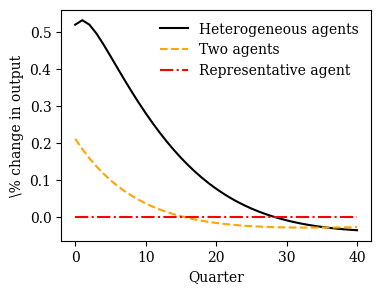

In [218]:
plt.plot(irfs_B['ha'][:41], label='Heterogeneous agents', color='black')
plt.plot(irfs_B['ta'][:41], label='Two agents', linestyle='dashed', color='orange')
plt.plot(irfs_B['ra'][:41], label='Representative agent', linestyle='dashdot', color='red')
plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2a_deficit_by_model.pdf', bbox_inches='tight')

### 3(ii). Alternative assumptions and policy rules
We now perform, in the same order they are listed, the alternative experiments in Figure 2(b) and Figure 4(b), 

#### Tax changes at margin on highest earners

In [219]:
# replace regular fiscal rule with rule that taxes the richest at the margin
common_blocks_richest = common_blocks.copy()
common_blocks_richest[2] = fiscal_richest
model_ha_richest = sj.combine(common_blocks_richest + [hh_ha])

irf_B_richest = model_ha_richest.solve_impulse_linear(ss['ha'], unknowns=['Y'], targets=['asset_mkt'],
                                                      inputs={'B': dB}, outputs=['Y'])['Y']

#### Taylor rule
For this rule, we need to calculate inflation `pi` as an additional unknown, adding the NKPC residual as an additional target. We also need to add the `taylor_rule` block to the model, specifying its additional parameters.

In [220]:
ss_taylor = ss['ha'].copy()
ss_taylor['phi'], ss_taylor['rstar'] = 1.5, r
model_ha_taylor = sj.combine(common_blocks + [hh_ha, taylor_rule])
irf_B_taylor = model_ha_taylor.solve_impulse_linear(ss_taylor, unknowns=['Y', 'pi'], targets=['asset_mkt', 'nkpc_res'],
                                               inputs={'B': dB}, outputs=['Y'], Js=Js)['Y']

#### Angeletos-Lian-Wolf tax rate rule
For this rule, total debt $B$ is endogenously determined subject to a rule that sets the tax rate equal to the steady state plus some shock (which we enforce by setting the previously defined `tax_rate_res` residual to zero):

In [221]:
irf_B_ALW = models['ha'].solve_impulse_linear(ss['ha'], unknowns=['Y', 'B'], targets=['asset_mkt', 'tax_rate_res'],
                                             inputs={'tax_rate_shock': dT_shock}, outputs=['Y'], Js=Js)['Y']


#### Figure 2(b)
We summarize the additional results we've obtained so far in Figure 2(b):

<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_91100/1917097920.py:9: SyntaxWarning: invalid escape sequence '\%'


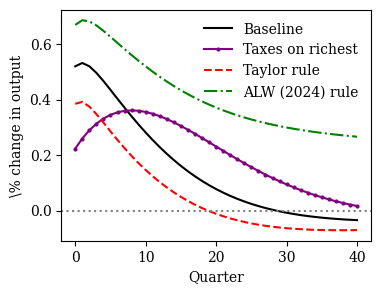

In [222]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2b_deficit_alternative_rules.pdf', bbox_inches='tight')

<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/var/folders/cr/71dt26rx1ljbqzzzxpwv5g6r0000gn/T/ipykernel_91100/1917097920.py:9: SyntaxWarning: invalid escape sequence '\%'


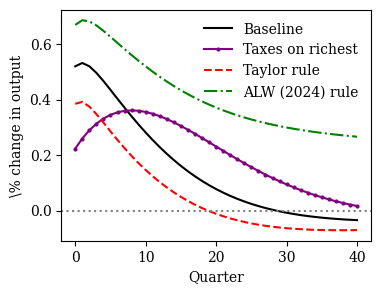

In [223]:
plt.plot(irfs_B['ha'][:41], label='Baseline', color='black')
plt.plot(irf_B_richest[:41], label='Taxes on richest', linestyle='-', color='#800080', marker='o', markersize=2)
plt.plot(irf_B_taylor[:41], label='Taylor rule', linestyle='dashed', color='red')
plt.plot(irf_B_ALW[:41], label='ALW (2024) rule', linestyle='dashdot', color='green')
plt.axhline(y=0, linestyle='dotted', color='gray')

plt.legend(frameon=False)
plt.xlabel('Quarter')
plt.ylabel('\% change in output')
plt.savefig('figures/figure2b_deficit_alternative_rules.pdf', bbox_inches='tight')

In [224]:
### Targets on the paper: